In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from env import *
from agent import *
from skmultiflow.data import FileStream
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential, EvaluateHoldout
from skmultiflow.data.base_stream import Stream
from skmultiflow.utils import check_random_state

In [2]:
# categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
categories = [10, 8, 5, 6, 5, 7, 10, 10, 10, 4, 8, 9, 5, 7, 10, 6, 2, 3, 2, 8]
d = len(categories)
labels = [0, 1]
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -.5) for i in range(len(categories))])

# Define the one-hot encoder.
encoder = Encoder(categories=categories)

In [3]:
env = EnvironmentDQN(generator, rewards_queries, encoder, r_plus=5, r_minus=-5, split=4)
agent = AgentDQN(categories=categories)

In [4]:
agent.load_weights('dqn_weights/dqn_weights_99000.pth')

In [5]:
agent.test(env, 10000)

1.0

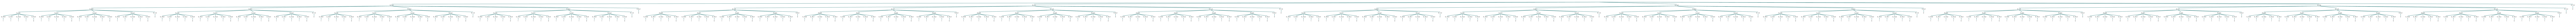

In [6]:
agent.plot_tree(encoder)

In [4]:
class StreamGenerator(Stream):
    
    def __init__(self, random_state=None, categories=[3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5], labels=[0, 1], split=4):
        
        super().__init__()
        
        self.random_state = random_state
        self._random_state = None  # This is the actual random_state object used internally
        self.categories = categories
        self.n_cat_features = len(categories)
        self.generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
        self.n_targets = 1
        self.split = split
        self.n_classes = len(labels)
        self.n_features = self.n_cat_features
        self.name = "Generator"
        self.feature_names = ["att_num_" + str(i) for i in range(self.n_features)]
        self.target_names = ["target_0"]
        self.target_values = [i for i in range(self.n_classes)]
        self._prepare_for_use()
        
    def _prepare_for_use(self):
        
        self._random_state = check_random_state(self.random_state)
        
    def concept(self, data_point):
        """
        Description
        --------------
        Define the concept labeling the data points. we can define it as a decision tree for example.
        
        Parameters
        --------------
        data_point : List of length d, the data point to label.
        
        Returns
        --------------
        Int in {0, 1}, the label of the data point.
        """
        
        label = True
        i = 0
        while label and i <= self.n_features-1:
            if data_point[i] >= self.split:
                label = False
                
            i += 1
            
        return label

    def next_sample(self, batch_size=1):
        
        data_point = [np.random.choice(self.categories[i], p=self.generator[i]) for i in range(self.n_features)]
        self.current_sample_x, self.current_sample_y = np.array([data_point]), np.array([self.concept(data_point)])
        return self.current_sample_x, self.current_sample_y
        
        

In [6]:
stream = StreamGenerator(categories=categories, split=9)

In [7]:
ht = HoeffdingTreeClassifier()

In [8]:
# evaluator = EvaluatePrequential()
evaluator = EvaluateHoldout(test_size=10000)

In [9]:
evaluator.evaluate(stream=stream, model=ht)

Holdout Evaluation
Evaluating 1 target(s).
Separating 10000 holdout samples.
Evaluating...
 #################### [100%] [176.42s]
Processed samples: 100000
Mean performance:
M0 - Accuracy     : 1.0000
M0 - Kappa        : 0.0000


[HoeffdingTreeClassifier(binary_split=False, grace_period=200,
                         leaf_prediction='nba', max_byte_size=33554432,
                         memory_estimate_period=1000000, nb_threshold=0,
                         no_preprune=False, nominal_attributes=None,
                         remove_poor_atts=False, split_confidence=1e-07,
                         split_criterion='info_gain', stop_mem_management=False,
                         tie_threshold=0.05)]

In [10]:
ht.measure_tree_depth()

5

In [11]:
ht.get_model_description()

'if Attribute 8 <= 8.181818181818182:\n  if Attribute 0 <= 8.181818181818182:\n    if Attribute 6 <= 8.181818181818182:\n      if Attribute 7 <= 8.181818181818182:\n        if Attribute 14 <= 8.181818181818182:\n          Leaf = Class 1 | {1: 48352.0}\n        if Attribute 14 > 8.181818181818182:\n          Leaf = Class 0 | {0: 5451.0}\n      if Attribute 7 > 8.181818181818182:\n        Leaf = Class 0 | {0: 5954.968695530798}\n    if Attribute 6 > 8.181818181818182:\n      Leaf = Class 0 | {0: 6971.462997284997}\n  if Attribute 0 > 8.181818181818182:\n    Leaf = Class 0 | {0: 7794.3659476919565}\nif Attribute 8 > 8.181818181818182:\n  Leaf = Class 0 | {0: 8959.082728255817}\n'

In [12]:
ht.get_model_rules()

[Rule(class_distribution=None, class_idx=1, drift_detector=None),
 Rule(class_distribution=None, class_idx=0, drift_detector=None),
 Rule(class_distribution=None, class_idx=0, drift_detector=None),
 Rule(class_distribution=None, class_idx=0, drift_detector=None),
 Rule(class_distribution=None, class_idx=0, drift_detector=None),
 Rule(class_distribution=None, class_idx=0, drift_detector=None)]

In [13]:
ht.get_rules_description()

'Att (8) <= 8.180 and Att (0) <= 8.180 and Att (6) <= 8.180 and Att (7) <= 8.180 and Att (14) <= 8.180 | class: 1\nAtt (8) <= 8.180 and Att (0) <= 8.180 and Att (6) <= 8.180 and Att (7) <= 8.180 and Att (14) > 8.180 | class: 0\nAtt (8) <= 8.180 and Att (0) <= 8.180 and Att (6) <= 8.180 and Att (7) > 8.180 | class: 0\nAtt (8) <= 8.180 and Att (0) <= 8.180 and Att (6) > 8.180 | class: 0\nAtt (8) <= 8.180 and Att (0) > 8.180 | class: 0\nAtt (8) > 8.180 | class: 0\n'